In [17]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import time 

# 전역 폰트 크기 설정
FONT_SIZE = 50  # 텍스트 크기
LABEL_FONT_SIZE = 30  # 예측 값 폰트 크기
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # 폰트 경로
THRESHOLD = 0.8  # 신뢰도 임계값

# YOLO 모델 로드
yolo_model_path = "yolov8n.pt"  # YOLO 모델 경로
yolo_model = YOLO(yolo_model_path)

# 클래스 매핑 및 색상
class_indices = {'BUS': 0, 'Bike': 1, 'Common': 2, 'Truck': 3}
index_to_class = {v: k for k, v in class_indices.items()}
class_colors = {
    'BUS': "blue",
    'Bike': "green",
    'HatchBack': "yellow",
    'SUV': "red",
    'Sedan': "cyan",
    'Truck': "purple",
    'Truck2': "magenta",
    'Van': "brown",
    'Common': "orange"
}

img_size = (128, 128)

def add_centered_text(draw, image, text, font_path=FONT_PATH, font_size=FONT_SIZE, color="black", bg_color="white", padding=10):

    """
    이미지 상단 중앙에 텍스트 추가 함수
    """
    if font_path:
        font = ImageFont.truetype(font_path, font_size)  # TrueType 폰트 사용
    else:
        font = ImageFont.load_default()  # 기본 폰트 사용

    image_width, image_height = image.size

    # 텍스트 크기 계산
    text_bbox = font.getbbox(text)  # 텍스트 경계 계산
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # 중앙 위치 계산
    x = (image_width - text_width) // 2
    y = 10  # 위쪽 여백

    # 배경 사각형 좌표 계산 (패딩 포함)
    bg_x1 = x - padding
    bg_y1 = y - padding
    bg_x2 = x + text_width + padding
    bg_y2 = y + text_height + padding

    # 배경 사각형 그리기
    draw.rectangle([bg_x1, bg_y1, bg_x2, bg_y2], fill=bg_color)

    # 텍스트 추가
    draw.text((x, y), text, font=font, fill=color)

def add_text(draw, x, y, text, font_path=FONT_PATH, font_size=LABEL_FONT_SIZE, color="black"):
    """
    지정된 위치에 텍스트 추가 함수
    """
    if font_path:
        font = ImageFont.truetype(font_path, font_size)  # TrueType 폰트 사용
    else:
        font = ImageFont.load_default()  # 기본 폰트 사용

    # 텍스트 추가
    draw.text((x, y), text, font=font, fill=color)

def plot_image_with_matplotlib(image, title="Image"):
    """
    이미지를 Matplotlib로 출력
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

def crop_to_square(image, box):
    """
    긴 쪽을 기준으로 정사각형으로 크롭
    """
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    size = max(width, height)

    # 중심 계산
    center_x = x1 + width // 2
    center_y = y1 + height // 2

    # 정사각형 좌표 계산
    new_x1 = max(center_x - size // 2, 0)
    new_y1 = max(center_y - size // 2, 0)
    new_x2 = min(new_x1 + size, image.size[0])
    new_y2 = min(new_y1 + size, image.size[1])

    # 좌표가 음수나 잘못된 값으로 변환되지 않도록 추가 조건
    new_x1 = max(0, new_x1)
    new_y1 = max(0, new_y1)

    # 이미지 크롭
    return image.crop((new_x1, new_y1, new_x2, new_y2))

def do_test(img_path):
    """
    YOLO 감지 및 CNN 분류 수행 (임계값 포함)
    """
    # 원본 이미지 로드
    original_image = Image.open(img_path)
    yolo_image = original_image.copy()
    classified_image = original_image.copy()

    # YOLO 감지 수행
    results = yolo_model(img_path)
    detected_boxes = results[0].boxes

    # YOLO 결과 그리기
    yolo_draw = ImageDraw.Draw(yolo_image)
    add_centered_text(yolo_draw, yolo_image, f"YOLO Model: {yolo_model_path}", font_size=FONT_SIZE, color="red")

    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            yolo_draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
            add_text(yolo_draw, x1, y1 - 60, f"Conf: {confidence:.2f}", font_size=LABEL_FONT_SIZE, color="red")

    plot_image_with_matplotlib(np.array(yolo_image), title="YOLO Detection Results")

    # CNN 결과 그리기
    classified_draw = ImageDraw.Draw(classified_image)
    add_centered_text(classified_draw, classified_image, f"CNN Model: {os.path.basename(cnn_model_path)}", font_size=FONT_SIZE, color="blue")

    for box in detected_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])

        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            # 크롭 후 판별
            cropped_img = crop_to_square(original_image, (x1, y1, x2, y2)).resize(img_size)
            cropped_array = img_to_array(cropped_img) / 255.0
            cropped_array = np.expand_dims(cropped_array, axis=0)

            predictions = cnn_model.predict(cropped_array, verbose=0)
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            predicted_class_name = index_to_class[predicted_class_index]
            predicted_confidence = predictions[0][predicted_class_index]

            # 임계값 미만 결과 무시
            if predicted_confidence < THRESHOLD:
                continue

            # 박스와 클래스 이름 그리기
            box_color = class_colors.get(predicted_class_name, "black")
            classified_draw.rectangle([x1, y1, x2, y2], outline=box_color, width=5)
            add_text(classified_draw, x1, y2 + 10, f"{predicted_class_name} ({predicted_confidence:.2f})", font_size=LABEL_FONT_SIZE, color=box_color)

            # 크롭된 이미지 저장
            cropped_img.save(f"{os.path.splitext(img_path)[0]}_cropped_{predicted_class_name}.jpg")
            print(f"{os.path.splitext(img_path)[0]}_cropped_{predicted_class_name}.jpg")

    plot_image_with_matplotlib(np.array(classified_image), title="CNN Classification Results")

    yolo_image.save(f"{os.path.splitext(img_path)[0]}_yolo_results.jpg")
    classified_image.save(f"{os.path.splitext(img_path)[0]}_cnn_results.jpg")

def save_and_plot_comparison(results_list, grid_width=3, grid_height=3, output_path="comparison.jpg"):
    """
    모델 추론 결과 이미지를 가로 grid_width x 세로 grid_height 형태로 결합하여 비교 이미지 생성
    """
    # 결과 이미지 로드
    images = [Image.open(result) for result in results_list]

    # 이미지 개수가 그리드에 맞지 않을 경우 빈 공간 추가
    total_images = grid_width * grid_height
    while len(images) < total_images:
        blank_image = Image.new("RGB", images[0].size, (255, 255, 255))  # 흰색 빈 이미지 추가
        images.append(blank_image)

    # 개별 이미지 크기 (모든 이미지의 크기가 동일하다고 가정)
    image_width, image_height = images[0].size

    # 비교 이미지 크기 (그리드 크기)
    comparison_width = grid_width * image_width
    comparison_height = grid_height * image_height

    # 비교 이미지 생성
    comparison_image = Image.new("RGB", (comparison_width, comparison_height))

    # 결과 이미지를 비교 이미지에 배치
    for idx, img in enumerate(images):
        x_offset = (idx % grid_width) * image_width
        y_offset = (idx // grid_width) * image_height
        comparison_image.paste(img, (x_offset, y_offset))

    # 비교 이미지 저장
    comparison_image.save(output_path)
    print(f"비교 이미지 저장 완료: {output_path}")

    # Matplotlib로 비교 이미지 출력
    plt.figure(figsize=(15, 15))  # 큰 비교 이미지 출력
    plt.imshow(np.array(comparison_image))
    plt.axis("off")
    plt.title("Model Comparison")
    plt.show()

def do_test_with_yolo_and_models(img_path, model_paths):
    """
    YOLO 감지 결과를 기반으로 YOLO + 여러 모델 결과를 비교
    :param img_path: 입력 이미지 경로
    :param model_paths: CNN 모델 경로, 입력 크기, 클래스 매핑 리스트 [(model_path, resize_dims, class_mapping), ...]
    """
    # YOLO 결과 생성
    yolo_image = Image.open(img_path).copy()
    yolo_draw = ImageDraw.Draw(yolo_image)
    add_centered_text(yolo_draw, yolo_image, f"YOLO Model: {yolo_model_path}", font_size=FONT_SIZE, color="red")

    results = yolo_model(img_path)
    detected_boxes = results[0].boxes

    for i, box in enumerate(detected_boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        if class_id in [2, 3, 5, 7]:  # 자동차, 트럭, 버스, 오토바이 클래스
            yolo_draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
            add_text(yolo_draw, x1, y1 - 60, f"Conf: {confidence:.2f}", font_size=LABEL_FONT_SIZE, color="red")

            # 감지된 객체 크롭 및 저장
            cropped_img = Image.open(img_path).crop((x1, y1, x2, y2))
            output_dir = "./yolo_cropped_images"
            os.makedirs(output_dir, exist_ok=True)  # 저장 디렉토리 생성
            cropped_filename = os.path.join(output_dir, f"{os.path.basename(img_path).split('.')[0]}_{i}.jpg")
            cropped_img.save(cropped_filename)
            print(f"YOLO cropped image saved: {cropped_filename}")

    # YOLO 결과 이미지 저장
    yolo_result_path = f"{os.path.splitext(img_path)[0]}_yolo_results.jpg"
    yolo_image.save(yolo_result_path)

    # 모델별 결과 생성
    results_list = [yolo_result_path]

    for model_path, resize_dims, class_mapping in model_paths:
        print(f'now {model_path}\n')
        start_time = time.time()
        cnn_model = load_model(model_path)
        model_name = os.path.basename(model_path)

        classified_image = Image.open(img_path).copy()
        classified_draw = ImageDraw.Draw(classified_image)
        add_centered_text(classified_draw, classified_image, f"Used Model: {model_name}", font_size=FONT_SIZE, color="blue")

        model_times = [] 

        for box in detected_boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            #if class_id in [2, 3, 5, 7]:
                # 크롭 후 사용자 정의 크기로 리사이즈
            cropped_img = crop_to_square(Image.open(img_path), (x1, y1, x2, y2)).resize(resize_dims)
            cropped_array = img_to_array(cropped_img) / 255.0
            cropped_array = np.expand_dims(cropped_array, axis=0)

            predictions = cnn_model.predict(cropped_array, verbose=0)
            print(f"Predictions: {predictions}")
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            predicted_confidence = predictions[0][predicted_class_index]
            print(f"Predicted Class Index: {predicted_class_index}, Confidence: {predicted_confidence}")


            # 클래스 매핑 사용
            try:
                predicted_class_name = class_mapping[predicted_class_index]
            except KeyError:
                print(f"알 수 없는 클래스 예측: {predicted_class_index}")
                continue

            if predicted_confidence < THRESHOLD:
                continue

            box_color = class_colors.get(predicted_class_name, "black")
            classified_draw.rectangle([x1, y1, x2, y2], outline=box_color, width=5)
            add_text(classified_draw, x1, y2 + 10, f"{predicted_class_name} {predicted_confidence:.2f}", font_size=LABEL_FONT_SIZE, color=box_color)

        result_path = f"{os.path.splitext(img_path)[0]}_{model_name}_results.jpg"
        classified_image.save(result_path)
        results_list.append(result_path)

        end_time = time.time() 
        elapsed_time = end_time - start_time
        model_times.append((model_name, elapsed_time))
        print(f"Model {model_name} processed in {elapsed_time:.2f} seconds.")

    # 비교 이미지 생성
    save_and_plot_comparison(results_list, output_path="comparison.jpg")


image 1/1 /mnt/d/noise/0-ml-team-project-pm-noise/Tester/test_img_2/test12.jpg: 384x640 1 person, 5 cars, 48.9ms
Speed: 2.4ms preprocess, 48.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
YOLO cropped image saved: ./yolo_cropped_images/test12_0.jpg
YOLO cropped image saved: ./yolo_cropped_images/test12_1.jpg
YOLO cropped image saved: ./yolo_cropped_images/test12_2.jpg
YOLO cropped image saved: ./yolo_cropped_images/test12_3.jpg
YOLO cropped image saved: ./yolo_cropped_images/test12_4.jpg
now ../Jupyter/DenseNet121_epoch30/DenseNet121_epoch30.h5



Predictions: [[          0           0           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[ 1.4583e-35  8.5518e-32           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[    0.29788     0.68645  1.2699e-05     0.01566]]
Predicted Class Index: 1, Confidence: 0.6864466071128845
Predictions: [[          0           0           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[ 1.3955e-05       0.957    0.036532   0.0064581]]
Predicted Class Index: 1, Confidence: 0.9569963812828064
Predictions: [[   0.025932     0.94677    0.021624   0.0056688]]
Predicted Class Index: 1, Confidence: 0.9467747807502747
Model DenseNet121_epoch30.h5 processed in 4.71 seconds.
now ../Jupyter/DenseNet121_weights/DenseNet121_weight.h5



Predictions: [[          0           0           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[          0           0           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[ 7.7829e-05     0.99992  4.9635e-07  1.0902e-06]]
Predicted Class Index: 1, Confidence: 0.9999206066131592
Predictions: [[          0           0           1           0]]
Predicted Class Index: 2, Confidence: 1.0
Predictions: [[  1.515e-08  0.00021743     0.99978  8.2993e-09]]
Predicted Class Index: 2, Confidence: 0.9997826218605042
Predictions: [[    0.29464     0.38728     0.28393    0.034149]]
Predicted Class Index: 1, Confidence: 0.38727882504463196
Model DenseNet121_weight.h5 processed in 5.65 seconds.
now ../Jupyter/ResNet50/ResNet50.h5



Predictions: [[   0.014647  1.6768e-05     0.89661    0.088722]]
Predicted Class Index: 2, Confidence: 0.8966142535209656
Predictions: [[   0.034051  0.00040273     0.76651     0.19904]]
Predicted Class Index: 2, Confidence: 0.7665061354637146
Predictions: [[    0.82829    0.075052   0.0081825    0.088479]]
Predicted Class Index: 0, Confidence: 0.8282864093780518
Predictions: [[   0.056193   0.0089379     0.85584     0.07903]]
Predicted Class Index: 2, Confidence: 0.8558389544487
Predictions: [[      0.107   0.0019935     0.33162     0.55938]]
Predicted Class Index: 3, Confidence: 0.5593802332878113
Predictions: [[   0.047623     0.29387     0.39363     0.26487]]
Predicted Class Index: 2, Confidence: 0.39363229274749756
Model ResNet50.h5 processed in 3.17 seconds.
now ../Jupyter/EfficientNetB0/EfficientNetB0.h5



Predictions: [[    0.25053     0.27022     0.25732     0.22193]]
Predicted Class Index: 1, Confidence: 0.27022218704223633
Predictions: [[     0.2506     0.27017     0.25731     0.22193]]
Predicted Class Index: 1, Confidence: 0.27016907930374146
Predictions: [[     0.2506     0.27018      0.2573     0.22191]]
Predicted Class Index: 1, Confidence: 0.270184725522995
Predictions: [[    0.25055     0.27021     0.25731     0.22193]]
Predicted Class Index: 1, Confidence: 0.27020755410194397
Predictions: [[    0.25053     0.27022     0.25732     0.22193]]
Predicted Class Index: 1, Confidence: 0.2702198922634125
Predictions: [[    0.25064     0.27016      0.2573     0.22191]]
Predicted Class Index: 1, Confidence: 0.2701556384563446
Model EfficientNetB0.h5 processed in 3.13 seconds.
비교 이미지 저장 완료: comparison.jpg


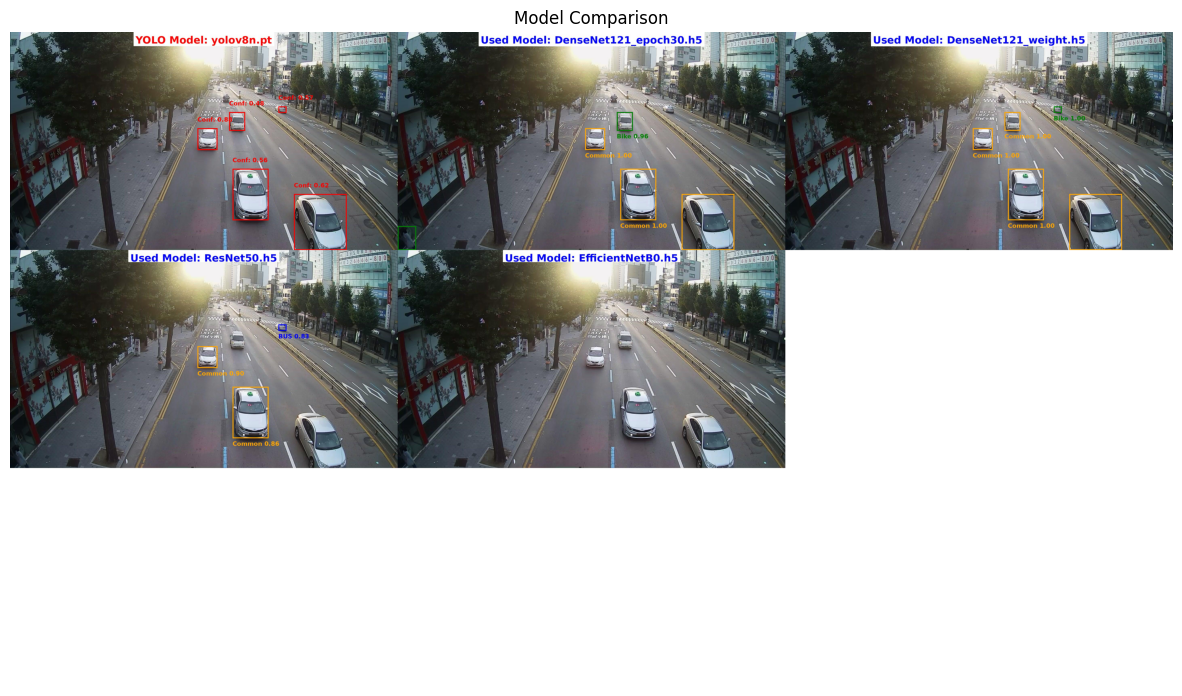

In [18]:
# 클래스 매핑
class_mapping_8_class = {
    0: 'BUS',
    1: 'Bike',
    2: 'HatchBack',
    3: 'SUV',
    4: 'Sedan',
    5: 'Truck',
    6: 'Truck2',
    7: 'Van'
}
class_mapping_4_class = {
    0: 'BUS',
    1: 'Bike',
    2: 'Common',
    3: 'Truck'
}

# 비교할 CNN 모델 리스트 (경로, 리사이즈 크기, 클래스 매핑)
model_paths = [
    ("../Jupyter/DenseNet121_epoch30/DenseNet121_epoch30.h5", (128, 128), class_mapping_4_class),
    ("../Jupyter/DenseNet121_weights/DenseNet121_weight.h5", (128, 128), class_mapping_4_class),

    ("../Jupyter/ResNet50/ResNet50.h5", (128, 128), class_mapping_4_class),
    #("../Jupyter/DenseNet121/DenseNet121.h5", (128, 128), class_mapping_4_class),
    #("../Jupyter/MobileNet/MobileNet.h5", (128, 128), class_mapping_4_class),
    
    ("../Jupyter/EfficientNetB0/EfficientNetB0.h5", (224, 224), class_mapping_4_class),
    # ("../Jupyter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_5.h5", (128, 128), class_mapping_4_class),
    # ("../Jupyter/cnn_4_class/cnn_4_class_2/cnn_4_class_2_6.h5", (128, 128), class_mapping_4_class),
]

# 테스트 이미지
# test_image = "./test_img_2/test11.jpg"
test_image = "./test_img_2/test12.jpg" # resnet의 예시로 적합
# 모델 비교 수행
do_test_with_yolo_and_models(test_image, model_paths)


In [19]:
# 생성한 이미지 삭제

import os
import fnmatch

target_foler = './test_img_2'

for file in os.listdir(target_foler):
    if fnmatch.fnmatch(file, 'test?*.jpg') and len(file) >= 15:
        print(f"Deleting file: {file}")
        os.remove(f'{target_foler}/{file}')  # 파일 삭제

Deleting file: test12_cnn_4_class_2_5.h5_results.jpg
Deleting file: test12_DenseNet121_epoch30.h5_results.jpg
Deleting file: test12_DenseNet121_weight.h5_results.jpg
Deleting file: test12_EfficientNetB0.h5_results.jpg
Deleting file: test12_ResNet50.h5_results.jpg
Deleting file: test12_yolo_results.jpg
